# Topic 8: Regularization

## Reading: Bishop 5.5

## 1 Motivating regularization

“YEAH, BUT YOUR SCIENTISTS WERE SO PREOCCUPIED WITH WHETHER OR NOT THEY COULD THAT THEY DIDN’T STOP TO THINK IF THEY SHOULD.” -- Dr. Ian Malcolm

<img src="images/goldblum.jpg">


We now have the power to create functions (namely neural networks) that have the power to approximate any other function, given a sufficient number of parameters.  However, as we learned when we were fitting polynomials to curves all the way back at the start of the class, unlimited model complexity is a path fraught with peril.  Recall that if we have a simple dataset like this one:  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9,9)

np.random.seed(0)

# Create constantly-spaced x-values
x = np.linspace(0,1,11)

# Create a linear function of $x$ with slope 1, intercept 1, and normally distributed error with sd=1
y = x + np.random.randn(len(x))*0.1 + 1.0
y_test = x + np.random.randn(len(x))*0.1 + 1.0
plt.plot(x,y,'k.')
plt.plot(x,y_test,'r*')
plt.show()

<Figure size 900x900 with 1 Axes>

We can fit arbitrarily complex models such that we hit the training data exactly

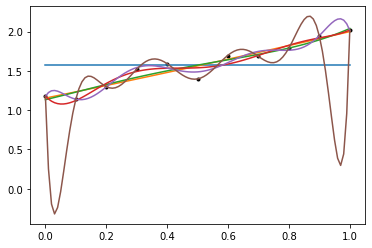

In [2]:
plt.plot(x,y,'k.')
x_smooth = np.linspace(0,1,101)
train_errors = []
test_errors = []
degrees = range(1,13,2)
for d in degrees:
    X = np.vander(x,d,increasing=True)
    w = np.linalg.solve(X.T @ X,X.T@y)
    y_pred = X@w
    plt.plot(x_smooth,np.vander(x_smooth,d,increasing=True)@w)
    training_error = 1./len(y)*np.sum((y_pred-y)**2)
    test_error = 1./len(y_test)*np.sum((y_pred-y_test)**2)
    train_errors.append(training_error)
    test_errors.append(test_error)
    
plt.show()

If we then plot the resulting training set and test errors as a function of the number of degrees of freedom, we see this typical pattern:

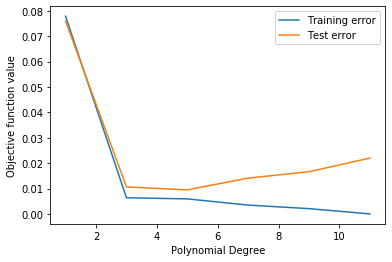

In [3]:
plt.plot(degrees,train_errors,label='Training error')
plt.plot(degrees,test_errors,label='Test error')
plt.xlabel('Polynomial Degree')
plt.ylabel('Objective function value')
plt.legend()
plt.show()    

The training error decreases with increased model complexity, while the test error initially decreases, then begins to *increase* as the model becomes more complex.

Of course this very same thing can happen in neural networks (linear regression is, after all, a very simple version of a multilayer perceptron with no hidden layers and the identity as an activation function).  In the case of linear regression, we made the simple choice to just limit our model complexity.  This is certainly possible with neural nets, by limiting the number of hidden layers and nodes.  However, it's a little bit more challenging to decide just exactly *where* overfitting is coming from, and to tailor the network in response.  Instead, we introduce a technique that we will refer to as *regularization*.  Regularization is broadly understood to be a technique that trades training set accuracy for test set accuracy, and there are a multitude of flavors: we'll explore a few of them here.  

## 2 $L_2$ Regularization
The most common idea for regularizing has been around for a very long time, and it results from the observation that in most regression problems, large weights tend to correspond to overfitting the data.  As such, we can make an effort to reduce overfitting by explicitly penalizing large parameters in the cost function.  In particular, we can simply add the following term:
$$
\mathcal{L}' = \underbrace{\mathcal{L}}_{\text{Sum Square Error}} + \frac{\gamma}{2}\; \sum_{l=1}^{L} \|W^{(l)}\|_{2}^2,
$$
where 
$$
\|W^{(l)}\|_2^2 = \sum_{i} \sum_{j} (w_{ij}^{(l)})^2
$$
is the square of the *Frobenius* norm, which generalizes the normal $L_2$ norm (aka Euclidean distance) to matrices.

## IC8A
$L_2$ regularization has many names including ridge regression and Tikhonov regularization.  However, in the world of machine learning, it is often called **weight decay**.  Compute the derivative of $\frac{\gamma}{2}\; \sum_{l=1}^L \|W^{(l)}\|_2^2$ with respect to some arbitrary weight $w_{ij}^{(l)}$ (ignore the misfit component of the cost function for now), and determine the resulting gradient descent update formula, e.g.
$$
w_{ij}^{(l)} \leftarrow w_{ij}^{(l)} - \ldots
$$
**Why is it called weight decay?**

## 2a $L_2$ Regularization for linear regression
The result derived above is general, but when applied to the linear regression problem we can write down the closed form solution for the optimal parameters as
$$
(X^T X + \gamma \mathcal{I}) \mathbf{w} = X^T y,
$$
where $\mathcal{I}$ is an appropriately sized identity matrix (The additive term along the matrix diagonal gives rise to the name *ridge regression*).  **What does the parameter $\gamma$ do**?

We can easily implement this for a high-dimensional problem, and explore what happens to our model fit as we adjust $\gamma$

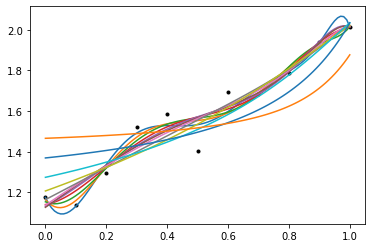

In [4]:
plt.plot(x,y,'k.')
x_smooth = np.linspace(0,1,101)
train_errors = []
test_errors = []
d = 13
gammas = np.logspace(-7,1,12)
for gamma in gammas:
    X = np.vander(x,d,increasing=True)
    identity = np.eye(X.shape[1])
    identity[0,0] = 0 # Why do I do this?
    w = np.linalg.solve(X.T @ X + gamma*identity,X.T@y)
    y_pred = X@w
    plt.plot(x_smooth,np.vander(x_smooth,d,increasing=True)@w)
    training_error = 1./len(y)*np.sum((y_pred-y)**2)
    test_error = 1./len(y_test)*np.sum((y_pred-y_test)**2)
    train_errors.append(training_error)
    test_errors.append(test_error)
    
plt.show()

Once again, we can look at the test and training accuracies together.

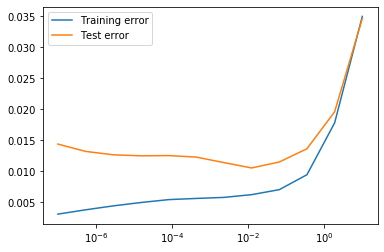

In [5]:
plt.semilogx(gammas,train_errors,label='Training error')
plt.semilogx(gammas,test_errors,label='Test error')
plt.legend()
plt.show()   

As similar picture emerges (although flipped around the x-axis, because a larger $\gamma$ corresponds to a simpler model.  

## 2b $L_2$ Regularization for neural networks

As it turns out, this is simple to apply to neural networks as well.  To illustrate its effect, let's synthesize a very noisy dataset to be used for a classification problem.  This is not dissimilar to the iris data set, in the sense that there are classes that overlap one another in their features.

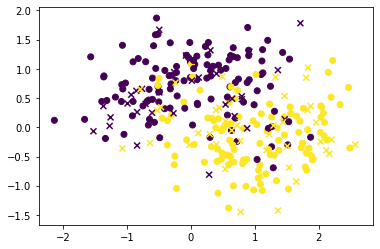

In [6]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=300,noise=0.4)

X,X_test,y,y_test = train_test_split(X,y)
X0,y0 = X.copy(),y.copy()
X0_test,y0_test = X_test.copy(),y_test.copy()

plt.scatter(X[:,0],X[:,1],c=y)
plt.scatter(X_test[:,0],X_test[:,1],c=y_test,marker='x')

There is a clear pattern here, but it is quite noisy.  Let's see if we can fit a very flexible neural network to this dataset using pytorch.  We'll first go through our ritual of converting the data into the appropriate type and location, and then create a DataLoader for use with batch gradient descent.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

X = torch.from_numpy(X)
X_test = torch.from_numpy(X_test)
y = torch.from_numpy(y)
y_test = torch.from_numpy(y_test)


X = X.to(torch.float32)
X_test = X_test.to(torch.float32)
y = y.to(torch.long)
y_test = y_test.to(torch.long)

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

X = X.to(device)
X_test = X_test.to(device)
y = y.to(device)
y_test = y_test.to(device)

from torch.utils.data import TensorDataset

training_data = TensorDataset(X,y)
test_data = TensorDataset(X_test,y_test)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 256
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size, 
                                           shuffle=False)

Now let's define our neural network.  It'll be a simple affair with a single hidden layer, but plenty of nodes to ensure a flexible function.  Something like the following:

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        """
        This method is where you'll want to instantiate parameters.
        we do this by creating two linear transformation functions, l1 and l2, which 
        have encoded in it both the weight matrices W_1 and W_2, and the bias vectors
        """
        super(Net,self).__init__()
        self.l1 = nn.Linear(2,2048) # Transform from input to hidden layer
        self.l2 = nn.Linear(2048,2)
    
    def forward(self,x):
        """
        This method runs the feedforward neural network.  It takes a tensor of size m x 784,
        applies a linear transformation, applies a sigmoidal activation, applies the second linear transform 
        and outputs the logits.
        """
        a1 = self.l1(x)
        z1 = torch.relu(a1)
        
        a2 = self.l2(z1)
        return a2

Now we can optimize.  Let's pay attention to the training and test set accuracy as we optimize.

0 0.6983544230461121 81.33333333333333 76.0
10 0.3985210061073303 85.33333333333333 80.0
20 0.3737606704235077 85.77777777777777 78.66666666666667
30 0.3543464243412018 86.66666666666667 81.33333333333333
40 0.3441130518913269 86.66666666666667 82.66666666666667
50 0.3391086459159851 86.22222222222223 82.66666666666667
60 0.3329841196537018 86.22222222222223 84.0
70 0.32808300852775574 86.22222222222223 84.0
80 0.32377129793167114 86.22222222222223 84.0
90 0.3197476267814636 86.66666666666667 84.0
100 0.31612613797187805 86.66666666666667 82.66666666666667
110 0.31289589405059814 86.66666666666667 82.66666666666667
120 0.3099699318408966 87.11111111111111 82.66666666666667
130 0.30727171897888184 86.66666666666667 82.66666666666667
140 0.3047831952571869 86.66666666666667 82.66666666666667
150 0.3024885058403015 87.11111111111111 82.66666666666667
160 0.30038541555404663 87.11111111111111 82.66666666666667
170 0.29844215512275696 87.11111111111111 82.66666666666667
180 0.29662346839904

1590 0.14217787981033325 94.66666666666667 73.33333333333333
1600 0.1414698213338852 94.66666666666667 72.0
1610 0.14078670740127563 95.11111111111111 70.66666666666667
1620 0.14026054739952087 95.11111111111111 72.0
1630 0.13937309384346008 95.11111111111111 73.33333333333333
1640 0.13871800899505615 94.66666666666667 74.66666666666667
1650 0.13797099888324738 95.55555555555556 73.33333333333333
1660 0.13731153309345245 95.11111111111111 72.0
1670 0.13666798174381256 95.11111111111111 72.0
1680 0.1359354853630066 95.55555555555556 73.33333333333333
1690 0.13524597883224487 95.55555555555556 74.66666666666667
1700 0.1346227377653122 95.55555555555556 74.66666666666667
1710 0.13411302864551544 95.55555555555556 74.66666666666667
1720 0.13337329030036926 95.55555555555556 72.0
1730 0.13263995945453644 95.11111111111111 74.66666666666667
1740 0.1319584846496582 95.55555555555556 74.66666666666667
1750 0.13130004703998566 95.55555555555556 74.66666666666667
1760 0.13071468472480774 95.5555

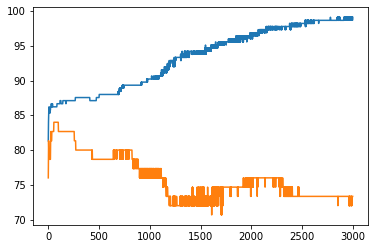

In [9]:
model = Net()
model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters())

epochs = 3000
# Loop over the data

train_accs = []
test_accs = []

for epoch in range(epochs):
    model.train()
    # Loop over each subset of data
    for d,t in train_loader:

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)      

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
    model.eval()
    # After each epoch, compute the test set accuracy
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
    total_train = 0
    correct_train = 0
    for d,t in train_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())
        
    # Print the epoch, the training loss, and the test set accuracy.
    train_accs.append(100.*correct_train/total_train)
    test_accs.append(100.*correct/total)
    if epoch%10==0:
        print(epoch,loss.item(),train_accs[-1],test_accs[-1])
plt.plot(train_accs,label='Training accuracy')
plt.plot(test_accs,label='Test accuracy')
plt.show()


**The above case exhibits the classic symptoms of overfitting.  How do you know?  Based on the plot above, can you identify an alternative method of regularization?**

This neural network only has two features, so we can easily visualize its predictions as a grid. Let's see what the decision boundary is.

In [10]:
X0grid,X1grid = np.meshgrid(np.linspace(X[:,0].cpu().min(),X[:,0].cpu().max(),101),np.linspace(X[:,1].cpu().min(),X[:,1].cpu().max(),101))

X_grid = np.vstack((X0grid.ravel(),X1grid.ravel())).T
X_grid = torch.from_numpy(X_grid)
X_grid = X_grid.to(torch.float32)
X_grid = X_grid.cuda()

t = model(X_grid)
out = F.softmax(t,dim=1)
plt.contourf(X0grid,X1grid,out.cpu().detach().numpy()[:,1].reshape((101,101)),alpha=0.5)
plt.scatter(X0[:,0],X0[:,1],c=y0,label='Training Data')
plt.scatter(X0_test[:,0],X0_test[:,1],c=y0_test,marker='x',label='Test Data')
plt.legend()
plt.show()

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

**What's the problem here?**

We can allay this issue using $L_2$ regularization.  How do we implement this?  As it turns out, it's not so bad.

0 0.8266308903694153 80.88888888888889 72.0
100 0.4432767927646637 86.66666666666667 84.0
200 0.3972565829753876 87.11111111111111 82.66666666666667
300 0.3680875599384308 87.11111111111111 82.66666666666667
400 0.3479064106941223 87.55555555555556 80.0
500 0.3336808383464813 87.55555555555556 80.0
600 0.3234896659851074 87.55555555555556 80.0
700 0.31624290347099304 87.55555555555556 80.0
800 0.3110135793685913 87.55555555555556 80.0
900 0.30716627836227417 87.55555555555556 80.0
1000 0.30432289838790894 87.11111111111111 80.0
1100 0.30213212966918945 87.11111111111111 80.0
1200 0.30036816000938416 87.11111111111111 80.0
1300 0.29888057708740234 87.11111111111111 80.0
1400 0.2975974678993225 87.11111111111111 80.0
1500 0.2964240312576294 87.55555555555556 80.0
1600 0.29534026980400085 87.55555555555556 80.0
1700 0.29431602358818054 87.55555555555556 80.0
1800 0.2933575510978699 88.0 80.0
1900 0.29246965050697327 88.0 80.0
2000 0.29164156317710876 88.44444444444444 80.0
2100 0.29084709

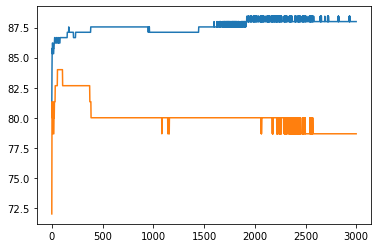

In [11]:
model = Net()
model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters())
gamma = 0.1  ### HERE'S THE REGULARIZATION PARAMETER!

train_accs = []
test_accs = []

epochs = 3000
# Loop over the data
for epoch in range(epochs):
    model.train()
    # Loop over each subset of data
    for d,t in train_loader:

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)
        
        ### HERE'S WHERE WE ADD REGULARIZATION!
        for W in model.parameters():
            # Loop over all the model parameters
            if W.dim()>1:
                # Loop over all the weight matrices (but not the biases)
                loss += gamma/(2*d.shape[0])*(W**2).sum()
        

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        # NOTE THAT THIS NOW INCLUDES A DIRECT DEPENDENCY ON THE PARAMETERS DUE TO THE REGULARIZATION TERM
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
    model.eval()
    # After each epoch, compute the test set accuracy
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
    total_train = 0
    correct_train = 0
    for d,t in train_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())
        
    # Print the epoch, the training loss, and the test set accuracy.
    train_accs.append(100.*correct_train/total_train)
    test_accs.append(100.*correct/total)
    if epoch%100==0:
        print(epoch,loss.item(),train_accs[-1],test_accs[-1])
        
plt.plot(train_accs,label='Training accuracy')
plt.plot(test_accs,label='Test accuracy')
plt.show()

**Does adding this regularization improve the overfitting issues?  How do you know?**

**Critically, what happens if we increase the regularization parameter too far?**

Let's print the resulting decision surface below.

In [12]:
X0grid,X1grid = np.meshgrid(np.linspace(X[:,0].cpu().min(),X[:,0].cpu().max(),101),np.linspace(X[:,1].cpu().min(),X[:,1].cpu().max(),101))

X_grid = np.vstack((X0grid.ravel(),X1grid.ravel())).T
X_grid = torch.from_numpy(X_grid)
X_grid = X_grid.to(torch.float32)
X_grid = X_grid.cuda()

t = model(X_grid)
out = F.softmax(t,dim=1)
plt.contourf(X0grid,X1grid,out.cpu().detach().numpy()[:,1].reshape((101,101)),alpha=0.5)
plt.scatter(X0[:,0],X0[:,1],c=y0)
plt.scatter(X0_test[:,0],X0_test[:,1],c=y0_test,marker='x')

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

## 2c $L_2$ Regularization for MNIST
As we've seen before, image data gives us an opportunity to look at the weights.  Because $L_2$ regularization is manipulating weights directly, this gives us an opportunity to get a sense of *what qualitative effect the regularization is having on the weights*.  Let's apply this to Labeled Faces in the Wild, which we're now used to seeing. 

As usual, the data manipulation ritual:

In [13]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True)
X/=255.
y = y.astype(int)
X,X_test,y,y_test = train_test_split(X,y,test_size=10000)

# Extract number of data points, and the height and width of the images for later reshaping
m = X.shape[0]
n = X.shape[1]

h = 28
w = 28

N = 10

In [14]:
X = torch.from_numpy(X)
X_test = torch.from_numpy(X_test)
y = torch.from_numpy(y)
y_test = torch.from_numpy(y_test)

X = X.to(torch.float32)
X_test = X_test.to(torch.float32)
y = y.to(torch.long)
y_test = y_test.to(torch.long)

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

X = X.to(device)
X_test = X_test.to(device)
y = y.to(device)
y_test = y_test.to(device)

In [15]:
from torch.utils.data import TensorDataset

training_data = TensorDataset(X,y)
test_data = TensorDataset(X_test,y_test)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 256
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size, 
                                           shuffle=False)

Now, let's construct a simple neural network, not dissimilar to the ones that you created 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        """
        This method is where you'll want to instantiate parameters.
        we do this by creating two linear transformation functions, l1 and l2, which 
        have encoded in it both the weight matrices W_1 and W_2, and the bias vectors
        """
        super(Net,self).__init__()
        self.l1 = nn.Linear(n,128) # Transform from input to hidden layer
        self.l2 = nn.Linear(128,N)
    
    def forward(self,x):
        """
        This method runs the feedforward neural network.  It takes a tensor of size m x 784,
        applies a linear transformation, applies a sigmoidal activation, applies the second linear transform 
        and outputs the logits.
        """
        a1 = self.l1(x)
        z1 = torch.sigmoid(a1)   
        a2 = self.l2(z1)
        
        return a2

First, let's try training the model without L2 regularization.  

In [17]:
model = Net()
model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
gamma=0
#gamma = 2e5

epochs = 30
# Loop over the data
for epoch in range(epochs):
    model.train()
    # Loop over each subset of data
    for d,t in train_loader:

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)
        for p in model.parameters():
            if p.dim()>1:
                loss += gamma/(2*d.shape[0])*(p**2).mean()
        

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
    model.eval()
    # After each epoch, compute the test set accuracy
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
    total_train = 0
    correct_train = 0
    for d,t in train_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),100.*correct_train/total_train,100.*correct/total)
params = [p for p in model.l1.parameters()]
W1_noreg = params[0].cpu().detach().numpy().T

0 0.42699411511421204 89.95833333333333 89.35
1 0.34738922119140625 92.22166666666666 91.4
2 0.194752499461174 93.39166666666667 92.66
3 0.25050610303878784 94.23 93.46
4 0.15573762357234955 94.97833333333334 94.35
5 0.1911446899175644 95.42833333333333 94.61
6 0.0718347355723381 95.86833333333334 94.89
7 0.1622544378042221 96.19333333333333 95.27
8 0.12679697573184967 96.56166666666667 95.55
9 0.072583869099617 96.86833333333334 95.68
10 0.1432713270187378 97.13333333333334 95.79
11 0.07982930541038513 97.3 96.16
12 0.04529954493045807 97.61 96.18
13 0.0547364242374897 97.74333333333334 96.29
14 0.07104914635419846 97.95666666666666 96.49
15 0.07196912914514542 98.105 96.57
16 0.0879911407828331 98.335 96.72
17 0.05058978497982025 98.42666666666666 96.82
18 0.06803538650274277 98.54333333333334 96.82
19 0.14800627529621124 98.65 97.01
20 0.08702331781387329 98.715 97.05
21 0.043761368840932846 98.87166666666667 97.14
22 0.02621648460626602 98.95666666666666 97.13
23 0.0253462363034486

Then, let's try it with regularization 

In [19]:
model = Net()
model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
gamma = 1e4

epochs = 30
# Loop over the data
for epoch in range(epochs):
    model.train()
    # Loop over each subset of data
    for d,t in train_loader:

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)
        for p in model.parameters():
            if p.dim()>1:
                loss += gamma/(2*d.shape[0])*(p**2).mean()
        

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
    model.eval()
    # After each epoch, compute the test set accuracy
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
    total_train = 0
    correct_train = 0
    for d,t in train_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),100.*correct_train/total_train,100.*correct/total)
params = [p for p in model.l1.parameters()]
W1_L2 = params[0].cpu().detach().numpy().T

0 1.3126611709594727 88.92666666666666 88.51
1 1.2588412761688232 90.39833333333333 89.72
2 1.258434534072876 90.94 90.35
3 1.2485542297363281 91.33666666666667 90.68
4 1.1645183563232422 91.42666666666666 90.91
5 1.4031102657318115 91.505 90.9
6 1.2105827331542969 91.62666666666667 91.0
7 1.3037283420562744 91.62666666666667 91.06
8 1.2299714088439941 91.67 91.11
9 1.166330337524414 91.72833333333334 91.23
10 1.329042673110962 91.82 91.08
11 1.1278395652770996 91.72666666666667 91.07
12 1.286921739578247 91.74666666666667 91.1
13 1.4044253826141357 91.725 91.21
14 1.2972218990325928 91.725 91.11
15 1.2612802982330322 91.58833333333334 91.07
16 1.31622314453125 91.86 91.33
17 1.1436169147491455 91.715 91.2
18 1.2663686275482178 91.73333333333333 91.16
19 1.2236731052398682 91.77833333333334 91.25
20 1.2407605648040771 91.745 91.04
21 1.20426344871521 91.76833333333333 91.29
22 1.292886734008789 91.75 91.21
23 1.141782283782959 91.77166666666666 91.24
24 1.3557755947113037 91.7183333333

Note that the regularized model has both reduced training set accuracy *and* reduced test set accuracy.  This implies that our regularization is not very useful: that's because this dataset is, in fact, not very "noisy" (in the sense of multiple overlapping data points of different classes; image data is usually this way because it's so high dimensional).  However, if we plot some of the features being extracted in the form of extracted weight matrices, we can learn something about the effect of $L_2$ regularization.

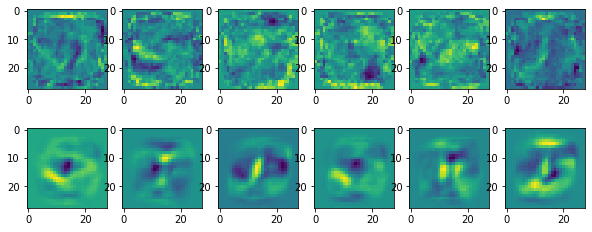

In [20]:
fig,axs = plt.subplots(nrows=2,ncols=6)
fig.set_size_inches(10,4)
for i in range(6):
    axs[0,i].imshow(W1_noreg[:,np.random.randint(W1_noreg.shape[1])].reshape((h,w)))
    axs[1,i].imshow(W1_L2[:,np.random.randint(W1_L2.shape[1])].reshape((h,w)))

Because $L_2$ regularization penalizes large weights more than small ones, it has the tendency to ensure that all the weights are around the same size, which also means that it tends towards extracting larger, smoother features.

## IC8B $L_1$ regularization
We chose to regularize by penalizing the sum of squared weights (if you don't believe this, go back to the formula).  However, there are many other ways that we could exert pressure on the weights to behave one way or another.  One very interesting possibility is so-called $L_1$ regularization, which penalizes the $L_1$ norm of the weights.  What, you ask, is the $L_1$ norm?  It is the *sum of absolute values*:
$$
\|W^{(l)}\|_1 = \sum_{i} \sum_{j} |w_{ij}^{(l)}|.
$$
Superficially, it would seem that this would do the same thing as $L_2$ regularization (make the weights smaller), and it is true that it does have this property.  However, it has a very different effect on the *distribution* of weights.  **Implement $L_1$ regularization, using the code above as a starting point.  Discuss the qualitative effect that this form of regularization has on the resulting weight matrices.**  Hint 1: (You might have to do a little bit of searching to find weight matrices that aren't all close to zero).  Hint 3: (Take the derivative of the $L_1$ norm.  At each iteration of gradient descent, how much are large weights reduced versus small weights?)

Finally, because there just aren't that many sensible norms in the world that we can penalize, there is a third form of direct regularization called *elastic net regularization*.  Despite the fancy name, it's just a combination of $L_1$ and $L_2$ regularization, each with their own weighting factor, which leads to the following objective function
$$ \mathcal{L}' = \mathcal{L} + \sum_{l=1}^L \left[ \frac{\delta}{m} \|W^{(l)}\|_1 + \frac{\gamma}{2 m} \|W^{(l)}\|_2^2 \right]. $$
**Implement elastic weight regularization, and comment on the type of features produced**

## 3 More exotic forms of regularization
Direct manipulation of weights is perhaps the most obvious way of making the model parameters behave in the way that we would like them to, but they don't often help much on problems of fundamental interest.  Perhaps that's because there's a bit of a jump between "Make the $L_1$ norm small" and "Don't overfit the data." More interesting mechanisms for regularization exist that force the model to perform the latter task in somewhat more direct and clever ways.

## 3A Dropout
If neural networks can (however tenuously) be thought of as an analog of an animal brain, then overfitting is reasonably well described as memorization.  For the student taking a test, instructors would prefer the student be able to answer a question in a constructive way by understanding the premise of the question being asked and thoughtfully constructing a response.  This is desirable because this mechanism *does not depend upon the specific way in which the question was asked*.  An alternative mechanism that less desirable students have been using forever is memorization: if the exact wording of the question (and its answer) are known beforehand, one can simply relate question to answer with no deeper intermediate analysis.  This latter is typically a great strategy for achieving training set accuracy, but very poor for test set accuracy.  

In the context of neural networks, these models often have sufficient degrees of freedom to simply memorize inputs.  As an extreme example, if the number of hidden layer nodes is similar to the number of data points, then weights can be adjusted such that exactly one hidden layer node gets activated for exactly one training example, and that hidden layer nodes has non-zero weight to exactly one softmax input.  Thus we have a network that sees a particular pattern of pixels (that it's seen before), and knows that that particular pattern corresponds to (say) a seven.  *Critically, come test time, a correct classification is only possible if the input is (nearly) exactly the same as what the network memorized*.  The useful capacity to weigh the contributions of different features is lost.

*Dropout* is a mechanism for ensuring that the above scenario does not occur.  It works as follows: for each training step, we select a random subset of nodes in a layer that we would like to apply dropout to (sometimes a hidden layer, sometimes an input layer, sometimes both), and *turn that node off*, i.e. set its output to zero.  This can be visualized with a classic plot from the [original paper by Srivastava et al.](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer) way back in 2014.

<img src="images/dropout.png">
Since the node is turned off, its forward mode output is equal to zero, which causes the gradient of any weights directly connected to it to be zero (**Can you show that this is true?**).  *Thus, the neural network is forced to learn to operate without only a random subset of its features available to it at any given time.* If only a random subset of features are available, then the network cannot rely on any given pattern, and thus it cannot simply memorize the training data! (A clever instructor might be able to develop questions that are similarly un-memorizable for their human pupils).  At test time, we don't drop nodes (that would be silly.  Why have them at all then?), but we do scale their outputs by the probability that they were dropped during the training process.  

Then dropout is easy to apply in pytorch: all we need to do is to instantiate a dropout layer and apply it after our activation function.  This essentially picks a random subset of the nodes with proportion $p$, and zeros out their output.

In [39]:
model = Net()
model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
gamma = 1e3

epochs = 30
# Loop over the data
for epoch in range(epochs):
    model.train()
    # Loop over each subset of data
    for d,t in train_loader:

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)
        for p in model.parameters():
            if p.dim()>1:
                #loss += gamma/(2*d.shape[0])*(abs(p)).mean()
                loss += gamma/(d.shape[0])*(torch.abs(p)).mean()
                #loss += gamma/(2*d.shape[0])*(np.absolute(p.detach().numpy())).mean()
        

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
    model.eval()
    # After each epoch, compute the test set accuracy
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
    total_train = 0
    correct_train = 0
    for d,t in train_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),100.*correct_train/total_train,100.*correct/total)
params = [p for p in model.l1.parameters()]
W1_L2 = params[0].cpu().detach().numpy().T

0 1.870295524597168 88.67 88.09
1 1.8036431074142456 90.80833333333334 90.35
2 1.4802154302597046 91.46166666666667 90.88
3 1.48024320602417 91.91666666666667 91.33
4 1.6092901229858398 92.18166666666667 91.77
5 1.4454597234725952 92.385 91.88
6 1.519876480102539 92.56666666666666 92.13
7 1.351029872894287 92.74833333333333 92.22
8 1.3419630527496338 92.90166666666667 92.38
9 1.2756690979003906 93.05666666666667 92.45
10 1.2657040357589722 93.185 92.49
11 1.2284998893737793 93.32666666666667 92.6
12 1.1808546781539917 93.475 92.65
13 1.1924140453338623 93.56666666666666 92.84
14 1.290475845336914 93.63833333333334 92.8
15 1.1642752885818481 93.765 92.96
16 1.2493685483932495 93.90833333333333 93.21
17 1.1043505668640137 94.03166666666667 93.23
18 1.1358109712600708 94.04833333333333 93.23
19 1.2625174522399902 94.16833333333334 93.39
20 1.2311809062957764 94.17833333333333 93.39
21 1.2328145503997803 94.34 93.44
22 1.1696442365646362 94.35666666666667 93.38
23 1.0770931243896484 94.49 

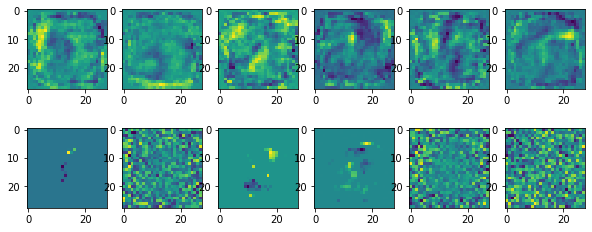

In [40]:
fig,axs = plt.subplots(nrows=2,ncols=6)
fig.set_size_inches(10,4)
for i in range(6):
    axs[0,i].imshow(W1_noreg[:,np.random.randint(W1_noreg.shape[1])].reshape((h,w)))
    axs[1,i].imshow(W1_L2[:,np.random.randint(W1_L2.shape[1])].reshape((h,w)))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        """
        This method is where you'll want to instantiate parameters.
        we do this by creating two linear transformation functions, l1 and l2, which 
        have encoded in it both the weight matrices W_1 and W_2, and the bias vectors
        """
        super(Net,self).__init__()
        self.l1 = nn.Linear(784,128) # Transform from input to hidden layer
        self.l2 = nn.Linear(128,10)
        
        # Instantiate dropout layers
        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.5)


    
    def forward(self,x):
        """
        This method runs the feedforward neural network.  It takes a tensor of size m x 784,
        applies a linear transformation, applies a sigmoidal activation, applies the second linear transform 
        and outputs the logits.
        """
        # Apply dropout to the input
        xd = self.dropout_1(x)
        a1 = self.l1(xd)
        z1 = torch.relu(a1)
        
        # Apply dropout to the hidden layer
        z1d = self.dropout_2(z1)
        
        a2 = self.l2(z1)

        return a2

Now, let's train the model using a similar loop as before.  

In [ ]:
model = Net()
model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

epochs = 50

total_train = 0
correct_train = 0
# Loop over the data
for epoch in range(epochs):
    model.train()
    # Loop over each subset of data
    for d,t in train_loader:

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)      

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())
        
    model.eval()
    # After each epoch, compute the test set accuracy
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),100.*correct_train/total_train,100.*correct/total)

Dropout has worked (in a way that $L_2$ or $L_1$ regularization clearly did not): we get close to 98.3% test set accuracy, a full 0.5% improvement over the unregularized case we saw before!  Clearly this improvement is marginal, but that last bit of accuracy is always the most challenging to achieve.

## 3B Data Augmentation
Dropout is a fantastic tool for encouraging neural networks to overfit, but it is still suboptimal when compared to the one and only true solution to overfitting: get more data.  This is the one method that always works to justify the inclusion of more complex and powerful models.  The problem of course is that it's often expensive and sometimes impossible.  For example, with the MNIST dataset, we can't just go collect new handwritten digits...  Or can we?

Consider the following digit images:

In [ ]:
fig,axs = plt.subplots(nrows=1,ncols=2)
axs[0].imshow(X[5].cpu().reshape((28,28)))

# What is being done here?
from scipy.ndimage import rotate
axs[1].imshow(rotate(X[5].cpu().reshape((28,28)),25,order=1,reshape=False))
plt.show()

These are both, of course, still the same digit, and that is immediately recognizable to your human visual processing system because somehow it's learned to be *rotationally invariant*.  However, we haven't explicitly taught our neural network that same property: all the rotational invariance it has learned is that which comes from the 60k training examples.  We can force it to learn that property by feeding the network training examples that we have explicitly rotated (probably randomly, and probably within a set range of viable rotations.  **What happens if we train on data that is randomly rotated in the full 360 degrees?**

The above process is called *data augmentation*, and is typically done in an *on-line* capacity, which means that as we load mini-batches, we perform some random transformation on each data point, then pass it on to the network as usual.  **Besides rotation, what kinds of transformations can you imagine that we might do on image data?**  We can implement this in pytorch with a custom data loader.

In [ ]:
import torch
from torch.utils.data import Dataset,TensorDataset
from torchvision import transforms

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True)
X/=255.
y = y.astype(int)
X,X_test,y,y_test = train_test_split(X,y,test_size=10000)

X = torch.from_numpy(X)
X_test = torch.from_numpy(X_test)
y = torch.from_numpy(y)
y_test = torch.from_numpy(y_test)

X = X.to(torch.float32)
X_test = X_test.to(torch.float32)
y = y.to(torch.long)
y_test = y_test.to(torch.long)

### NOTE THAT WE ARE NOT YET PLACING OBJECTS ON GPU ###

In [ ]:
# Define a random transform (20 degree rotation, 3 pixel translation, 
# scaling between 90% and 110%, and a 10 degree shear over the x-axis) 
transform = transforms.RandomAffine(20,translate=(0.1,0.1),scale=(0.9,1.1),shear=10)#,transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip()]

# Custom dataset object
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        # Define a __getitem__ method to be called by the 
        # mini-batch loader 
        
        x = self.tensors[0][index]

        if self.transform:
            # reshape data, apply transform, reflatten
            x = x.reshape((28,28))
            x = transforms.ToPILImage()(x)
            x = self.transform(x)
            x = transforms.ToTensor()(x)
            x = x.flatten()
            #print(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

training_data = CustomTensorDataset([X,y],transform=transform)
test_data = CustomTensorDataset([X_test,y_test])

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size, 
                                           shuffle=True,num_workers=24)

batch_size = 256
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size, 
                                           shuffle=False,num_workers=24)

Let's see the type of digits our augmented data set includes

In [ ]:
t = next(iter(train_loader))

import matplotlib.pyplot as plt
fig,axs = plt.subplots(nrows=5,ncols=6)
axs = axs.ravel()
for i,ax in enumerate(axs):
    ax.imshow(t[0][i].reshape((28,28)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

n = 784
N = 10

class Net(nn.Module):
    def __init__(self):
        """
        This method is where you'll want to instantiate parameters.
        we do this by creating two linear transformation functions, l1 and l2, which 
        have encoded in it both the weight matrices W_1 and W_2, and the bias vectors
        """
        super(Net,self).__init__()
        self.l1 = nn.Linear(n,128) # Transform from input to hidden layer
        self.l2 = nn.Linear(128,N)



    
    def forward(self,x):
        """
        This method runs the feedforward neural network.  It takes a tensor of size m x 784,
        applies a linear transformation, applies a sigmoidal activation, applies the second linear transform 
        and outputs the logits.
        """
        a1 = self.l1(x)
        z1 = torch.sigmoid(a1)
        
        a2 = self.l2(z1)

        return a2

Unfortunately, this model takes alot longer to train, mostly due to the overhead of augmentation (there are new libraries that allow augmentation to be done quickly and in situ on the GPU in order to help deal with this bottleneck).  We'll load a pre-trained model to help us get to results more quickly.  

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
#model = Net()
#model.to(device)
model = torch.load(open('trained_with_augmentation.p','rb'))
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
epochs = 50

total_train = 0
correct_train = 0
# Loop over the data
for epoch in range(epochs):
    model.train()
    # Loop over each subset of data
    for d,t in train_loader:
        # Move batches to GPU
        d,t = d.to(device),t.to(device)

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)  

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())
        
    model.eval()
    # After each epoch, compute the test set accuracy
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        d,t = d.to(device),t.to(device)
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),100.*correct_train/total_train,100.*correct/total)

Data augmentation has gotten us to test set accuracies in excess of 98.5%, nearly a full percentage point better than the unregularized data!  This is a remarkable improvement for just jiggling our dataset a bit.  However, it makes sense why it works: the model never trains on the same data point twice, making memorization quite impossible.  Additionally, this property leads to some very compelling looking weight images.

In [ ]:
params = [p for p in model.parameters()]
W1 = params[0].cpu().detach().numpy().T
fig,axs = plt.subplots(nrows=1,ncols=6)
fig.set_size_inches(10,4)
for i in range(6):
    axs[i].imshow(W1[:,np.random.randint(W1.shape[1])].reshape((28,28)))

No pixel can ever really be relied upon to produce a definitive categorization, so the model has instead learned to recognize broader patterns that are more easily recognizable.  Interestingly, if you know something about classical image processing or numerical partial differential equations, some of the images above will look familiar: asymmetrical patches of positive and negative values are associated with taking the gradient of an image, while a positive patch surrounded by negative patches are analogous to taking the laplacian (essentially the second derivative, or *curvature* of an image).  We've long known that these are nice filters to apply for extracting relevant features from an image; our neural network has just learned these filters on its own!  This notion of *explicitly learning filters* to be applied to images (or any structured data, as we will see) for feature extraction turns out to be a very powerful idea that gives rise to the basis for the current state of the art in image processing (and various tasks in bioinformatics and audio analysis), the *convolutional neural network*.  